# Data retrieval from the Long-Term Archive

Sentinel data that has not been accessed for a longer period of time is moved to a Long-Term Archive (LTA).
Data in the LTA can not be retrieved immediately but instead has to moved out of this archive first.

This notebook shows how API responses in this case look like and what to do in this situation.
The relevant part is at the end of this notebook, the rest is documented for the sake of completeness.

## Defining the area of interest

The data retrieval process looks like in other notebooks:
The sentinelsat API client is initialized and the geometry of an area of interest is fetched using OpenStreetMap nominatim and narrowed down using GeoPandas.

In [1]:
from sentinel_helpers import search_osm, geodataframe_on_map
from datetime import date
import os
from sentinelsat import SentinelAPI
from tqdm.notebook import tqdm

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

In [2]:
jueterbog = search_osm('Jüterbog, Brandenburg')
jueterbog = jueterbog[(jueterbog['type'] == 'administrative') & (jueterbog['osm_type'] == 'relation')]
jueterbog

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,257891092,relation,422436,"Jüterbog, Teltow-Fläming, Brandenburg, 14913, ...",16,boundary,administrative,0.685236,https://nominatim.openstreetmap.org/ui/mapicon...,"POLYGON ((12.95605 52.03939, 12.96134 52.03944..."


In [3]:
geodataframe_on_map(jueterbog)

The API query is initialized for a time span we are interested in and using an area that slightly extends the geometry fetched from OpenStreetMap. This is done to increase the likelihood that the phenomenon we are interested in is visible on the products we download - we don't know where exactly we will need to look, we only know proximity.

In [4]:
start_date = date(2018, 7, 1)
end_date = date(2018, 8, 31)

# we increase the geometry size by buffering it by 2.5km
buffered = jueterbog.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326')
footprint = buffered.iloc[0].convex_hull.wkt

results = api.query(footprint,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(start_date, end_date),
                    cloudcoverpercentage=(0, 30))

gdf = SentinelAPI.to_geodataframe(results)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Deciding which products we are interested in

We are only interested in products that have a low cloud coverage value:

<AxesSubplot:xlabel='beginposition'>

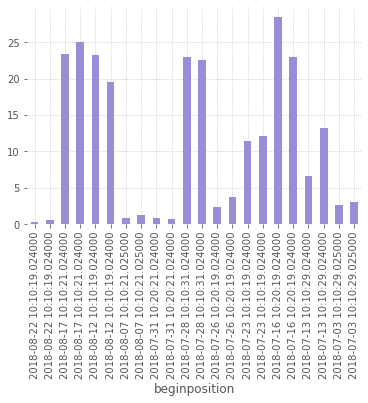

In [5]:
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

We also want to avoid merging or reprojecting adjacent tiles if possible, so we prefer tiles that easily cover the entire area of interest:

In [6]:
from sentinel_helpers import plot_all

plot_all([
    gdf, buffered
], [
    { 'facecolor': 'none', 'edgecolor': 'blue', 'alpha': 0.1 },
    { 'facecolor': 'none', 'edgecolor': 'red' }
])

ImportError: cannot import name 'plot_all' from 'sentinel_helpers' (/home/jovyan/sources/sentinel_helpers.py)

We can subset the result to only take products covering one tile because they all cover the area well.
We select one product before, one during and one after the fire:

In [ ]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf = gdf[gdf['tile'] == 'T32UQC']
gdf = gdf.sort_values(by='beginposition')

before = gdf.iloc[0]
during = gdf.loc['ad590142-a9f2-49a8-8be7-2a6c06454514']
after = gdf.iloc[-1]

### Download process from LTA

In [ ]:
downloads, initialized, failed = api.download_all([before['uuid'], during['uuid'], after['uuid']])

The dict containing information about succesful donwloads is empty:

In [ ]:
downloads

The second dict contains information about one product.
Notice that the key `'Online'` is `False`: 

In [ ]:
initialized

The `failed` downloads contains information about two products.
The individual dict entries have a similar shape and contain information comparable to the `initialized` product:

In [ ]:
failed

In [ ]:
len(downloads), len(initialized), len(failed)

`failed` means that a retrieval process could not yet be initialized.
Other instances of failure included an exception that was raised due to an unexpected response of the Copernicus Open Access Hub API with an HTTP response code of `200` - a code that normally indicates that the request was successful.
It is unclear why that response was unexpected.

Through repeated execution of the cell containing the call to `api.download_all`, all products could be moved from the Long-Term Archive to hot storage and could be downloaded.
The first products could be downloaded after one day and the last product after approximately two days.
Note that the last product might have been available earlier than two days because the re-execution of this cell was a manual process with intermissions.